In [1]:
import os
import wecgrid

wec_grid = wecgrid.Engine()

In [2]:
wec_grid.case(f"{os.getcwd()}/../data/grid_models/IEEE_30_bus.raw")
wec_grid.load(["psse","pypsa"])

PSS®E software initialized
PyPSA software initialized


SLD Data Summary:
  Buses: 30
  Lines: 37
  Generators: 6
  Loads: 21


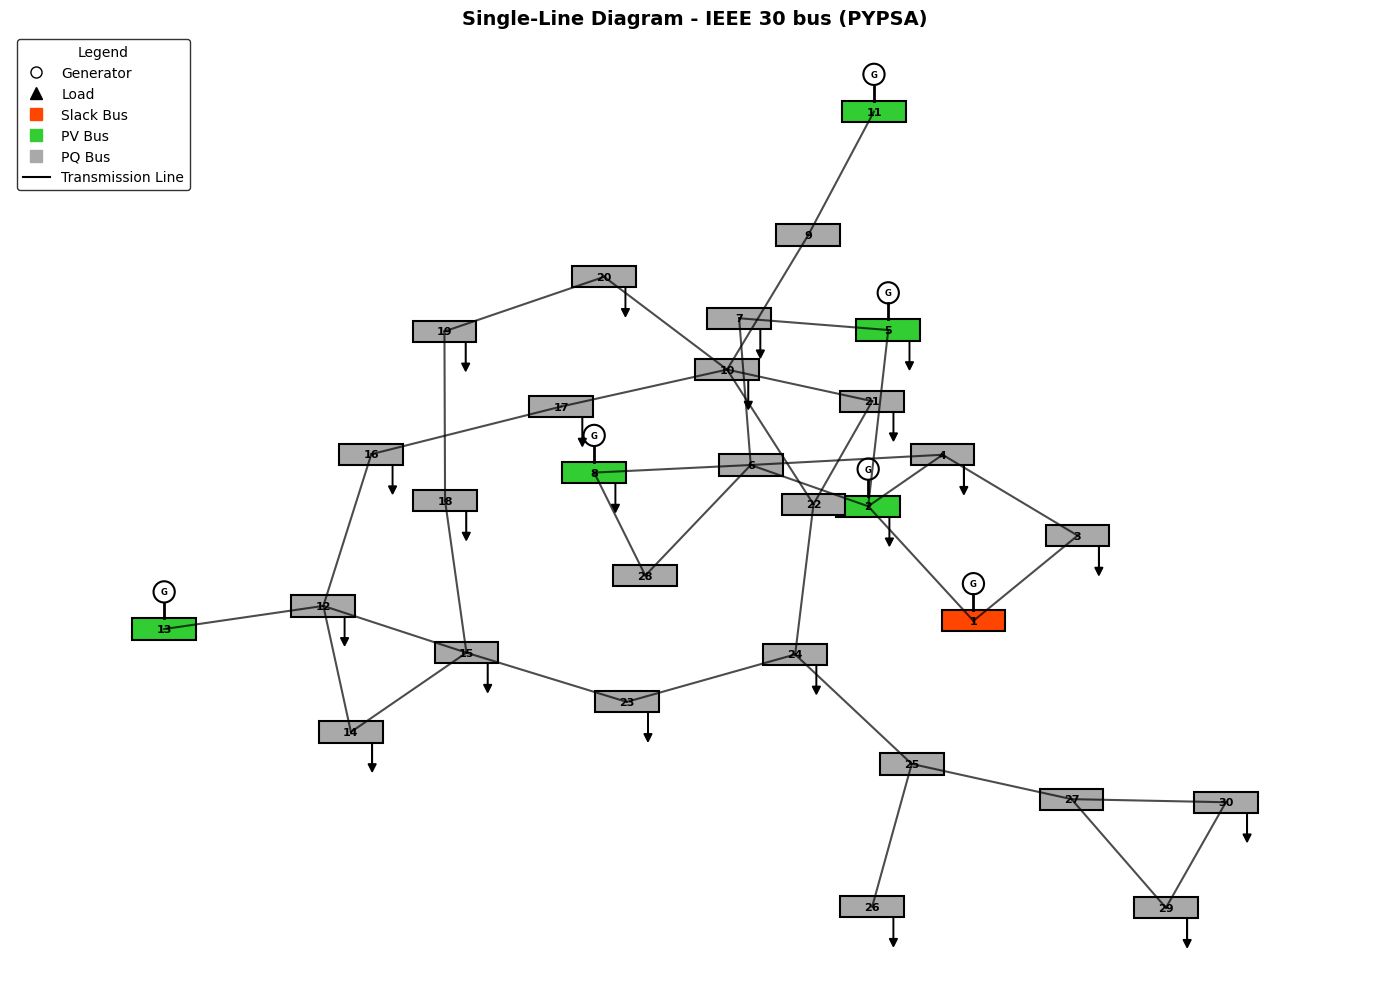

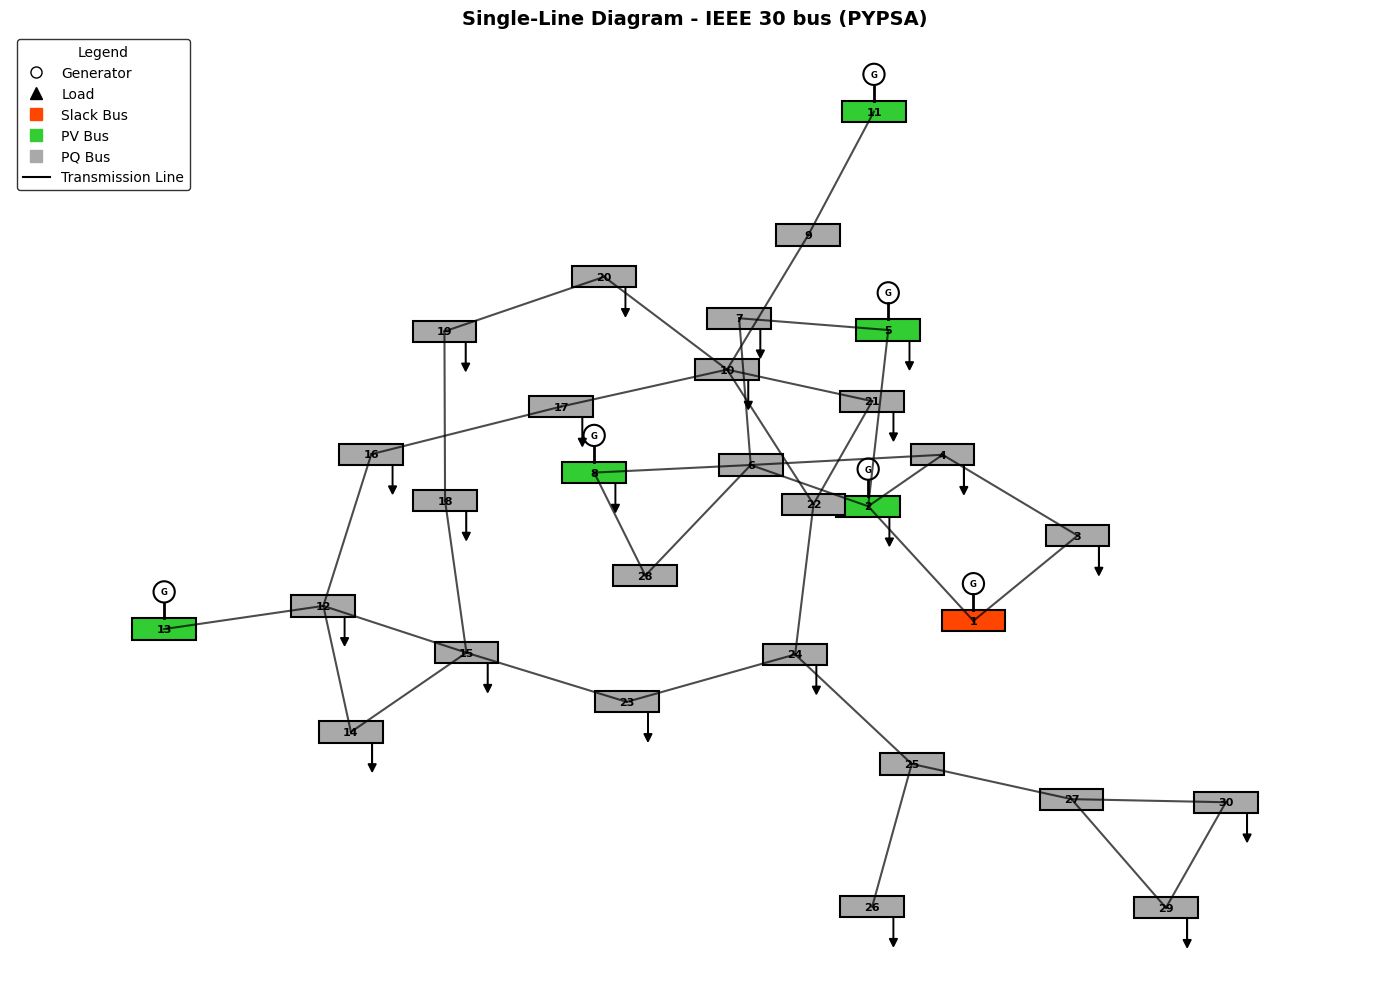

In [9]:
wec_grid.plot.sld("pypsa")

In [3]:
wec_grid.apply_wec(
   farm_name = "WEC-Farm",
   size = 10, 
   wec_sim_id = 1, # LUPA run 
   bus_location=31,
   connecting_bus = 1,
   scaling_factor = 10 # scale up the lab scale to about a 1kW
)

In [4]:
wec_grid.apply_wec(
   farm_name = "WEC-Farm-1",
   size = 1, 
   wec_sim_id = 2, # RM3 run 
   bus_location=32,
   connecting_bus = 1,
)

In [5]:
wec_grid.simulate(load_curve=True, sim_length=20)

PSS®E Simulating:   0%|          | 0/20 [00:00<?, ?step/s]

PyPSA Simulating: 100%|██████████| 20/20 [00:06<00:00,  3.02step/s]


In [ ]:
wec_grid.

Time-series data columns for gen.p: ['Gen_1', 'Gen_2', 'Gen_3', 'Gen_4', 'Gen_5', 'Gen_6', 'Gen_7', 'Gen_8']
Time-series data shape: (20, 8)
Plotting all 8 components
Plotting 8 components over 20 time steps


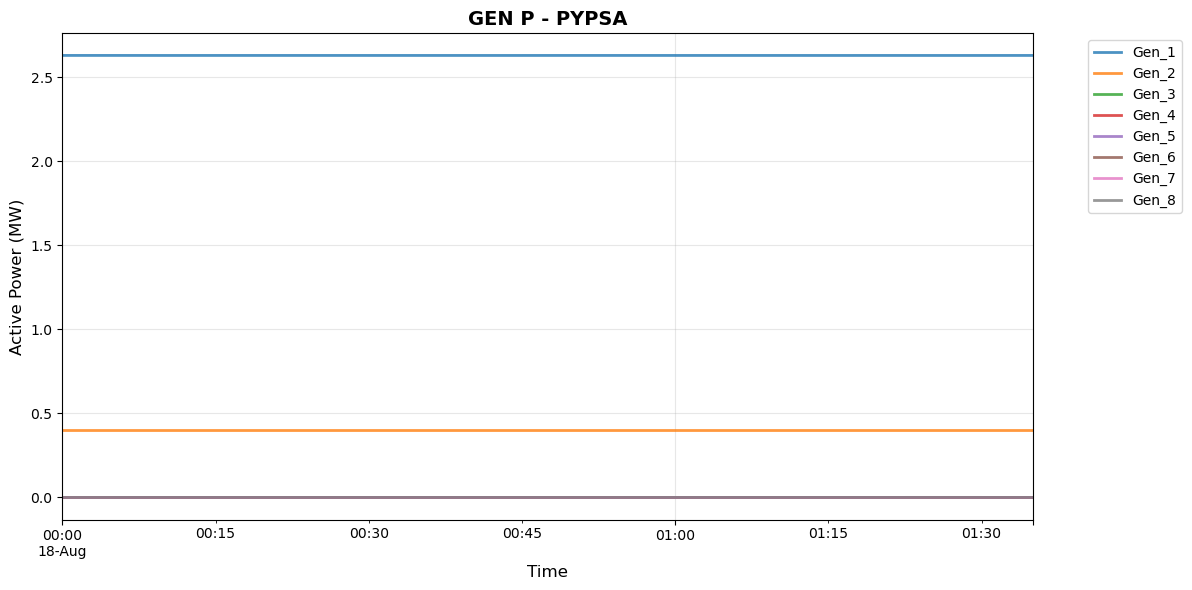

(<Figure size 1200x600 with 1 Axes>,
 <AxesSubplot:title={'center':'GEN P - PYPSA'}, xlabel='Time', ylabel='Active Power (MW)'>)

In [9]:
engine = wec_grid

engine.plot.generator(software='pypsa')


Plotting 8 components over 20 time steps


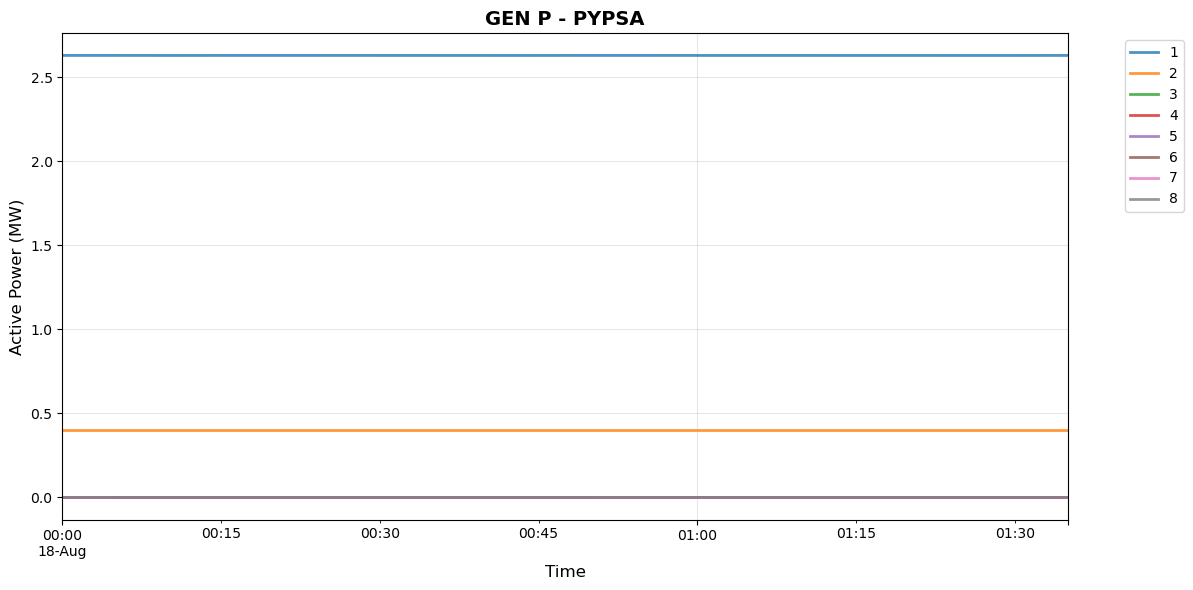

(<Figure size 1200x600 with 1 Axes>,
 <AxesSubplot:title={'center':'GEN P - PYPSA'}, xlabel='Time', ylabel='Active Power (MW)'>)

In [10]:
wec_grid.plot.plot_generator(software='pypsa')

Plotting 3 components over 20 time steps


TypeError: sequence item 0: expected str instance, int found

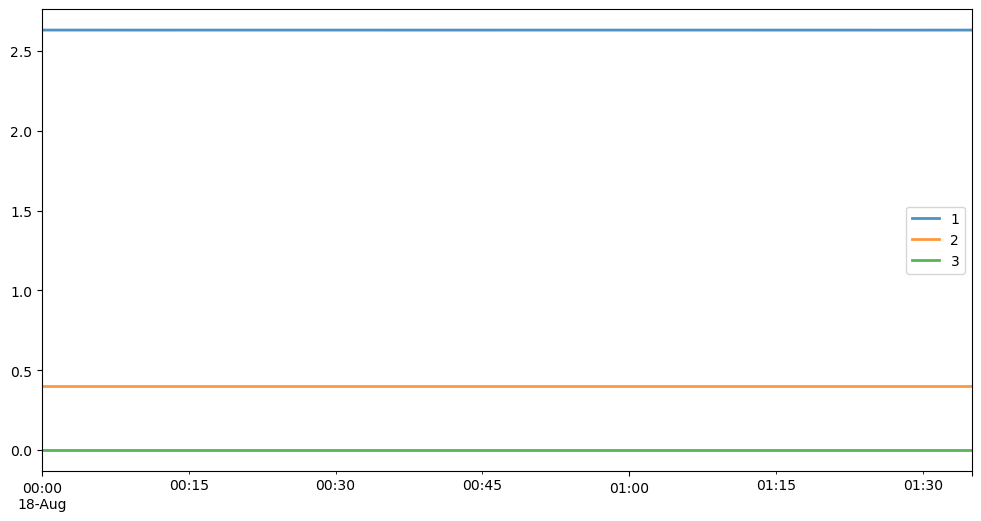

In [7]:
# Clean function calls (no more plot_ prefix)
#wec_grid.plot.generator(component_name=[1, 2, 3])
# wec_grid.plot.bus(parameter='v_mag', component_name=[1, 14, 23]) 
# wec_grid.plot.compare_software('gen', 'p', component_name=[1, 2])

# # GridState compatibility maintained
# # Works with both integer and string component names
# wec_grid.plot.generator(component_name=[1, 2])      # Integer IDs
# wec_grid.plot.generator(component_name=['1', '2'])  # String IDs

In [8]:
wec_grid.psse

psse:
├─ case: IEEE 30 bus
├─ buses: 32
├─ generators: 8
├─ loads: 21
└─ lines: 39
Sbase: 100.0 MVA

In [13]:
wec_grid.plot.bus(component_name=[1])    

No valid components found to plot


(None, None)

In [26]:
wec_grid.plot.bus("psse", 1)
# wec_grid.plot.generator()
# wec_grid.plot.load()
# wec_grid.plot.line()

TypeError: hasattr(): attribute name must be string

In [17]:
bus = 1
software = "pypsa"
component = 'bus_t'
parameter = 'p'

grid_obj = getattr(wec_grid, software).grid
component_data = getattr(grid_obj, component)
data = getattr(component_data, parameter)
data = data[bus]
data

2025-08-18 00:00:00    2.135226
2025-08-18 00:05:00    2.135283
2025-08-18 00:10:00      2.1352
2025-08-18 00:15:00    2.135343
2025-08-18 00:20:00    2.135445
                         ...   
2025-08-18 23:35:00    2.303571
2025-08-18 23:40:00    2.294924
2025-08-18 23:45:00    2.286665
2025-08-18 23:50:00    2.278684
2025-08-18 23:55:00    2.271008
Name: 1, Length: 288, dtype: object

In [31]:
bus = 2
software = "psse"
component = 'load_t'
parameter = 'p'

grid_obj = getattr(wec_grid, software).grid
component_data = getattr(grid_obj, component)
data = getattr(component_data, parameter)
data = data[bus]
data

2025-08-18 00:00:00    0.020295
2025-08-18 00:05:00    0.020295
2025-08-18 00:10:00    0.020296
2025-08-18 00:15:00    0.020296
2025-08-18 00:20:00    0.020297
                         ...   
2025-08-18 23:35:00    0.021567
2025-08-18 23:40:00    0.021502
2025-08-18 23:45:00     0.02144
2025-08-18 23:50:00     0.02138
2025-08-18 23:55:00    0.021322
Name: 2, Length: 288, dtype: object

<AxesSubplot:xlabel='time'>

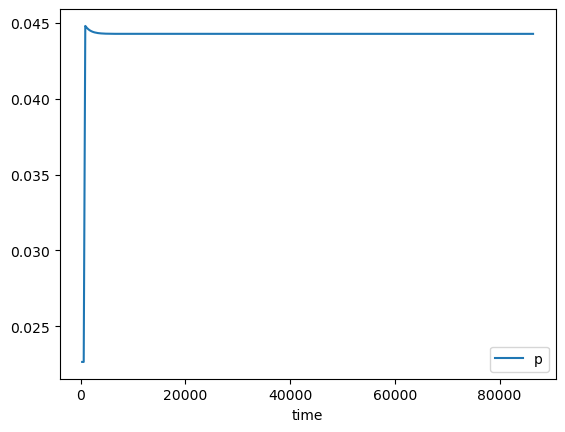

In [21]:
wec_grid.wec_farms[1].wec_devices[0].dataframe.plot('time','p')

<AxesSubplot:xlabel='time'>

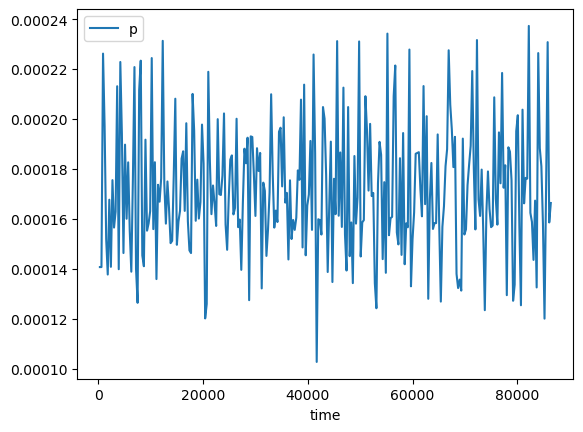

In [22]:
wec_grid.wec_farms[0].wec_devices[0].dataframe.plot('time','p')

In [3]:
wec_grid.simulate(load_curve=True)

ValueError: No power system modeler loaded. Use `engine.load(...)` first.


--- Comparison Metrics for GEN P ---
Found 7 common components for comparison
  1: MSE=8.09e-05, RMSE=0.009, MAE=0.009, MAPE=0.3%, R²=1.000
  2: MSE=0.00e+00, RMSE=0.000, MAE=0.000, MAPE=0.0%, R²=0.000
  3: MSE=0.00e+00, RMSE=0.000, MAE=0.000, MAPE=0.0%, R²=0.000
  4: MSE=0.00e+00, RMSE=0.000, MAE=0.000, MAPE=0.0%, R²=0.000
  5: MSE=0.00e+00, RMSE=0.000, MAE=0.000, MAPE=0.0%, R²=0.000
  6: MSE=0.00e+00, RMSE=0.000, MAE=0.000, MAPE=0.0%, R²=0.000
  7: MSE=3.22e-21, RMSE=0.000, MAE=0.000, MAPE=0.0%, R²=1.000

Overall Statistics (7 components):
  Mean MSE: 1.16e-05
  Mean RMSE: 0.001
  Mean MAE: 0.001
  Mean MAPE: 0.0%
  Mean R²: 0.286


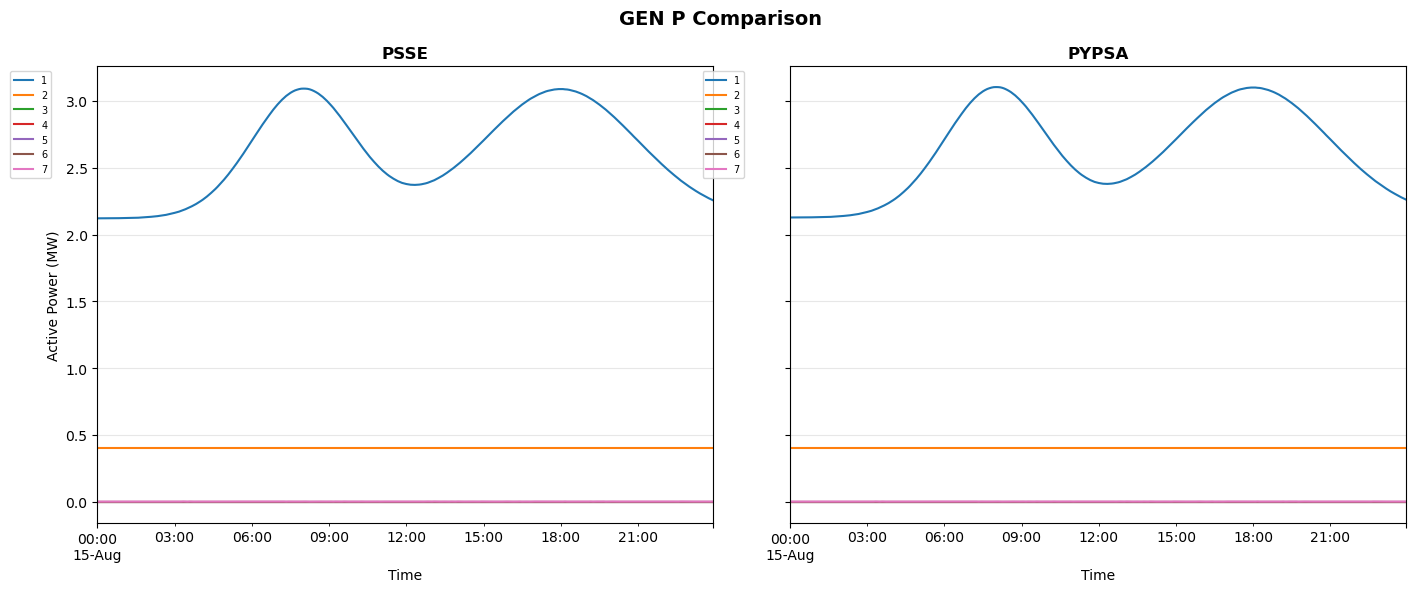

(<Figure size 1400x600 with 2 Axes>,
 (<AxesSubplot:title={'center':'PSSE'}, xlabel='Time', ylabel='Active Power (MW)'>,
  <AxesSubplot:title={'center':'PYPSA'}, xlabel='Time', ylabel='Active Power (MW)'>))

In [ ]:
wec_grid.plot.compare_software()

In [ ]:
wec_grid.database.save_sim(
    sim_name="IEEE_30_test",
    notes="testing the database"
)

Found PSS®E grid data
Found PyPSA grid data
Processing 2 software objects...
  Software 1: 'psse' (type: <class 'wecgrid.modelers.grid_state.GridState'>)
    Raw software attribute: 'psse'
  Using default sbase: 100.0 MVA
  Software 2: 'pypsa' (type: <class 'wecgrid.modelers.grid_state.GridState'>)
    Raw software attribute: 'pypsa'
Storing time-series data for PSSE...
  Storing data to psse_* tables...
Storing time-series data for PYPSA...
  Storing data to pypsa_* tables...
Storing WEC farm data...
  Storing WEC farm: WEC-Farm
    - Farm 'WEC-Farm' at bus 31
    - WEC sim ID: 3, devices: 10
  Stored 1 WEC farm integration(s)
Simulation saved with ID: 1
Software backends: PSS®E, PyPSA
Case: IEEE 30 bus
Time series data stored for 2 software(s)


1

In [ ]:
# New GridState access pattern
# Access PSS/E backend data
psse_voltage = wec_grid.system.psse.grid.bus_t.v_mag

# Access PyPSA backend data  
pypsa_voltage = wec_grid.system.pypsa.grid.bus_t.v_mag

print("PSS/E voltage data:", psse_voltage)
print("PyPSA voltage data:", pypsa_voltage)